In [1]:
import arviz as az
import matplotlib.dates as mdates
import pandas as pd
import causalpy as cp
import numpy as np
import matplotlib.pyplot as plt


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
%load_ext autoreload
%autoreload 2
pd.set_option("display.precision", 2)
seed = 42

# Bayesian SC vs Frequentist SC

In [695]:
def generate_geolift_data(n_years = 4, causal_impact = 0.2, treat_time = "2022-01-01", start_time = "2019-01-01", freq = "W"):
    """Generate synthetic data for a geolift example. This will consists of 6 untreated
    countries. The treated unit `Denmark` is a weighted combination of the untreated
    units. We additionally specify a treatment effect which takes effect after the
    `treatment_time`. The timeseries data is observed at weekly resolution and has
    annual seasonality, with this seasonality being a drawn from a Gaussian Process with
    a periodic kernel."""
    n_years = n_years
    treatment_time = pd.to_datetime(treat_time)
    causal_impact = causal_impact


    if freq not in ['W', 'D']:
        raise ValueError("freq must be either 'W' (weekly) or 'D' (daily).")
        
    n_periods = 52 if freq == 'W' else 365
        
    time = pd.date_range(start=start_time, periods=n_periods * n_years, freq=freq)

    untreated = [
        "Austria",
        "Belgium",
        "Bulgaria",
        "Croatia",
        "Cyprus",
        "Czech_Republic",
    ]

    df = (
        pd.DataFrame(
            {
                country: create_series(n_years=n_years, intercept=3, freq = freq)
                for country in untreated
            }
        )
        .assign(time=time)
        .set_index("time")
    )
    # intercept = np.random.randint(low = 2, high = 4)

    # create treated unit as a weighted sum of the untreated units
    weights = np.random.dirichlet(np.ones(len(untreated)), size=1)[0]
    df = df.assign(Denmark=np.dot(df[untreated].values, weights))
    print(weights)

    # add observation noise
    for col in untreated + ["Denmark"]:
        df[col] += np.random.normal(size=len(df), scale=0.1)

    # add treatment effect
    df["Denmark"] += np.where(df.index < treatment_time, 0, causal_impact)

    # ensure we never see any negative sales
    df = df.clip(lower=0)

    return df

def create_series(n=52, amplitude=1, length_scale=2, n_years=4, intercept=3, freq = 'W'):
    """
    Returns numpy tile with generated seasonality data repeated over
    multiple years
    """
    n = 52 if freq == 'W' else 365
    return np.tile(
        generate_seasonality(n=n, amplitude=amplitude, length_scale=2) + intercept,
        n_years,
    )

def generate_seasonality(n=12, amplitude=1, length_scale=0.5):
    """Generate monthly seasonality by sampling from a Gaussian process with a
    Gaussian kernel, using numpy code"""
    # Generate the covariance matrix
    x = np.linspace(0, 1, n)
    x1, x2 = np.meshgrid(x, x)
    cov = periodic_kernel(
        x1, x2, period=1, length_scale=length_scale, amplitude=amplitude
    )
    # Generate the seasonality
    seasonality = np.random.multivariate_normal(np.zeros(n), cov)
    return seasonality


def periodic_kernel(x1, x2, period=1, length_scale=1, amplitude=1):
    """Generate a periodic kernel for gaussian process"""
    return amplitude**2 * np.exp(
        -2 * np.sin(np.pi * np.abs(x1 - x2) / period) ** 2 / length_scale**2
    )

In [810]:
df = generate_geolift_data(n_years = 4, causal_impact = 0.2)
treatment_time = pd.to_datetime("2022-01-01")

[0.03613528 0.28884948 0.0436561  0.07609261 0.21758619 0.33768034]


In [811]:
df

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,Denmark
time,,,,,,,
2019-01-06,2.9599,2.1049,4.3522,1.1176,2.9863,2.8267,2.5523
2019-01-13,2.8581,2.2718,4.4382,1.2025,2.8839,2.9224,2.5864
2019-01-20,2.8769,2.1453,4.1379,1.4809,2.7711,3.2036,2.5675
2019-01-27,2.7604,2.1065,4.1578,1.4416,2.7450,3.2560,2.7783
2019-02-03,2.9335,2.1830,4.0469,1.4381,2.8738,3.3220,2.7808
...,...,...,...,...,...,...,...
2022-11-27,2.7799,2.3316,4.6479,0.9844,2.9339,2.6725,2.7810
2022-12-04,3.1642,2.3457,4.5455,1.1465,2.9650,2.6670,2.4776
2022-12-11,3.0843,2.2920,4.6038,1.2284,2.9823,2.4568,2.7879


In [781]:
# .difference({"Denmark"}): Removes "Denmark" from the set of column names.
def plot_time_series_data(df):
    untreated = list(set(df.columns).difference({"Denmark"}))
    ax = df[untreated].plot(color=[0.7, 0.7, 0.7])
    df["Denmark"].plot(color="r", ax=ax)
    ax.axvline(treatment_time, color="k", linestyle="--")
    ax.set(title="Observed data", ylabel="Sales volume (thousands)")

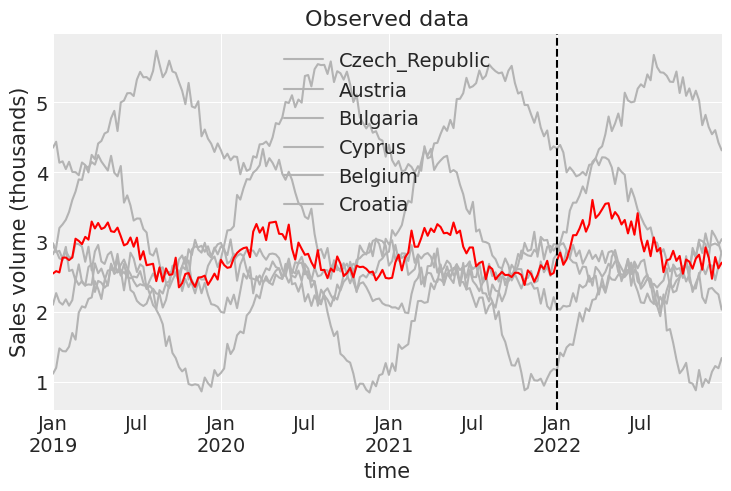

In [812]:
plot_time_series_data(df)

In [783]:
from causalpy.pymc_experiments import SyntheticControl as bayes_sc
from causalpy.skl_experiments import SyntheticControl as freq_sc

def bayesian_sc(df, formula, treatment_time):
    result_bayes = bayes_sc(
        df,
        treatment_time,
        formula=formula,
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={"target_accept": 0.95, "random_seed": seed}
        ),
    )
    return result_bayes

def freq_sc(df, formula, treatment_time):

    result_freq = SyntheticControl(
        df,
        treatment_time,
        formula=formula,
        model=cp.skl_models.WeightedProportion(),
    )
    return result_freq


    

In [813]:
result_bayes = bayesian_sc(df, formula, treatment_time)
result_freq = freq_sc(df, formula, treatment_time)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [702]:
def bayes_visualize(result, postfix = '0causalimpact'):
    fig1 = plt.figure(figsize=(8, 6))
    az.summary(result.idata, round_to=2)
    az.plot_trace(result.idata, var_names=["~mu"], compact=False)
    plt.savefig(f'mcmc_{postfix}.pdf')
    plt.show()
    plt.close()
    
    fig2 = plt.figure(figsize=(8, 6))
    az.plot_forest(result.idata, var_names=["~mu"], hdi_prob=0.9, figsize=(8, 3), combined=True)
    plt.savefig(f'hdi_{postfix}.pdf')
    plt.show()
    plt.close()

    fig, ax = result.plot(plot_predictors=False)
    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sales (thousands)")
    plt.savefig(f'trend_{postfix}.pdf')
    plt.show()
    plt.close()

    # get index of the final time point
    index = result.post_impact_cumulative.obs_ind.max()
    # grab the posterior distribution of the cumulative impact at this final time point
    last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
    # get summary stats
    ax = az.plot_posterior(last_cumulative_estimate, hdi_prob=0.9, figsize=(8, 4), round_to = 4)
    ax.set(
        title="Estimated cumulative causal impact (at end of 2022)",
        xlabel="Sales (thousands)",
    )
    plt.savefig(f'ci_{postfix}.pdf')
    plt.show()
    

<Figure size 800x600 with 0 Axes>

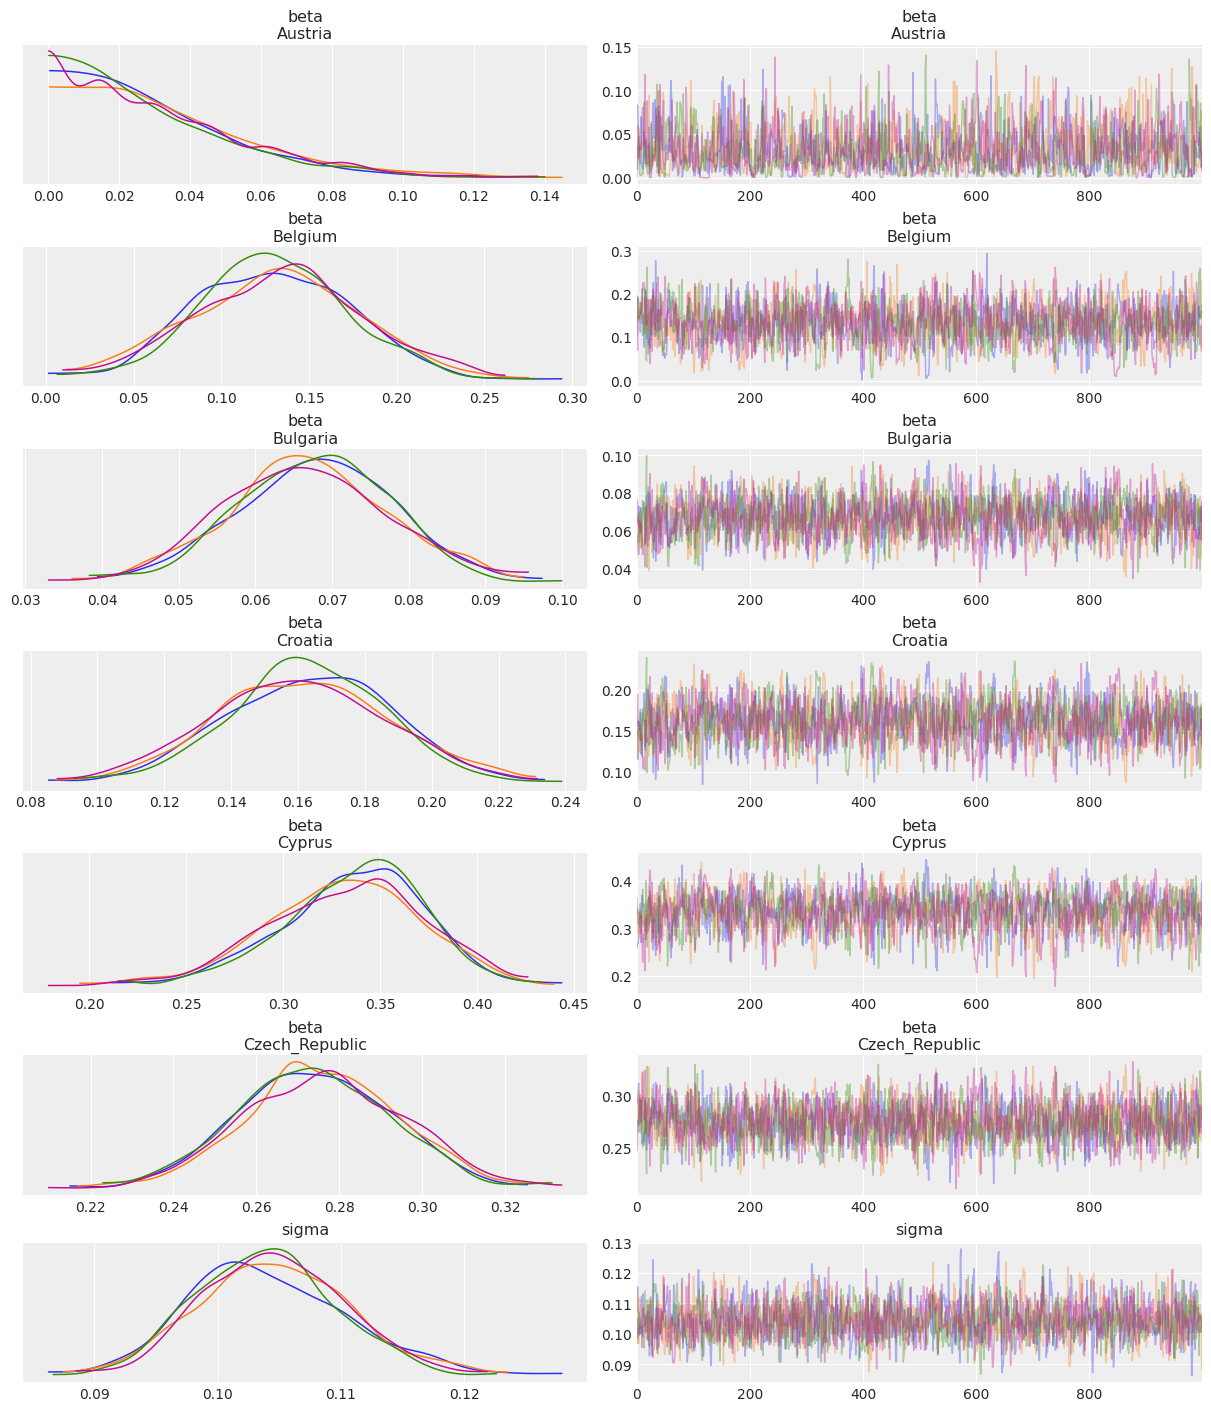

<Figure size 800x600 with 0 Axes>

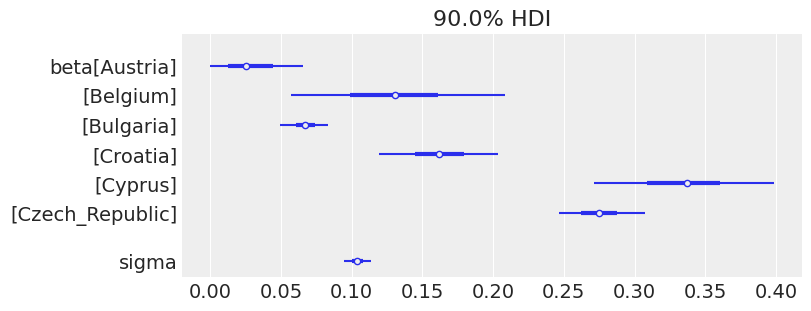

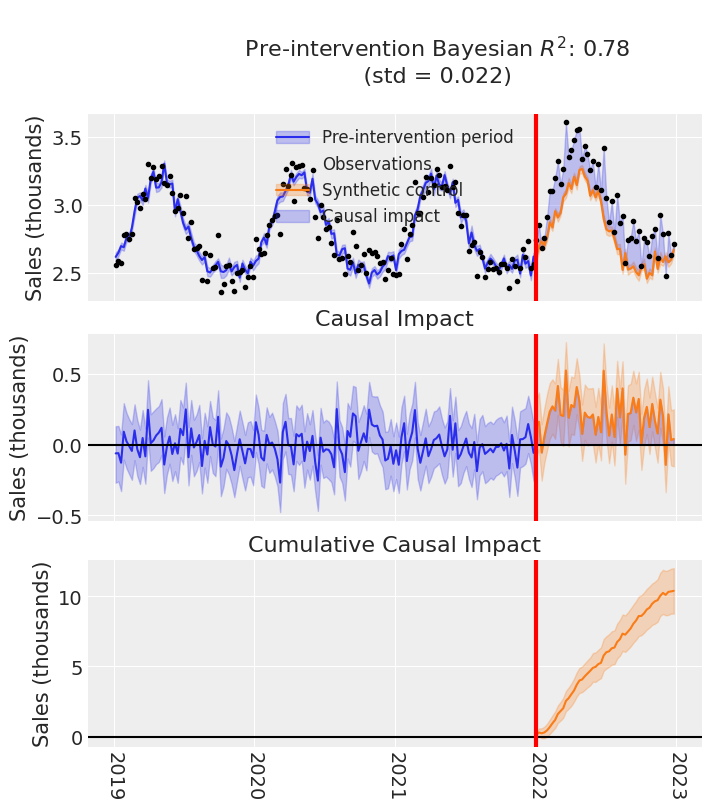

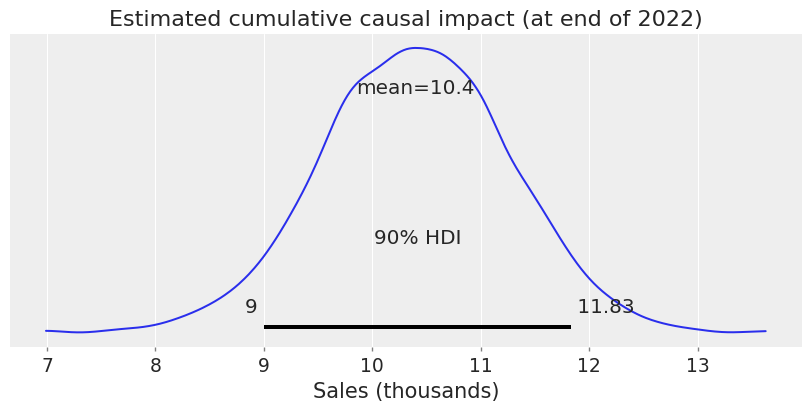

In [814]:
bayes_visualize(result_bayes, postfix = '0.2impact')

In [798]:
def get_bayes_result_summary(result_bayes):
    last_cumulative_estimate = result_bayes.post_impact_cumulative.sel({"obs_ind": index}, method="nearest")
    point_estimate = result_bayes.post_impact.sel({"obs_ind": index}, method="nearest")
    df_result_bayes_cum = az.summary(last_cumulative_estimate, hdi_prob=0.9, kind="stats")
    df_result_bayes_point = az.summary(point_estimate, hdi_prob=0.9, kind="stats")
    return df_result_bayes_cum, df_result_bayes_point
    

In [815]:
#df_result_bayes = get_bayes_result_summary(result_bayes)
df_result_bayes, df_result_bayes_point = get_bayes_result_summary(result_bayes)
#df_result3_bayes = get_bayes_result_summary(result_bayes3)

In [816]:
df_result_bayes

,mean,sd,hdi_5%,hdi_95%
x,10.398,0.873,9.0,11.833


In [789]:
plt.rcParams.update({'font.size': 8})

In [866]:
def get_freq_result(result_freq,  postfix = '0impact'):
    freq_est = result_freq.post_impact_cumulative[-1]
    freq_stderr = (result_freq.post_impact.std() / np.sqrt(len(result_freq.post_impact))) * 52
    ci_lower = freq_est - 1.625 *  freq_stderr
    ci_higher = freq_est + 1.625 * freq_stderr
    print(f"estiamted cumulative result from frequntist SC {freq_est}, 90CI {ci_lower, ci_higher}")
    fig, ax = result_freq.plot(plot_predictors=True)
    plt.savefig(f'freq_{postfix}.pdf')
    plt.show()

    return freq_est, ci_lower, ci_higher

def compare_freq_bayes(result_freq, result_bayes, causal_effect_gt, freq_est, df_result_bayes, postfix = '0impact', freq ='W'):
    n_periods = 52 if freq == 'W' else 356
    bayes_est = df_result_bayes['mean']['x'] 
    bayes_bias = bayes_est - causal_effect_gt * n_periods
    bayes_freq = freq_est - causal_effect_gt * n_periods
    print(f"bayes bias{bayes_bias}, frequentist bias {bayes_freq}")
    
    post_time = result_freq.datapost.index.to_list()
    causal_effect_true = causal_effect_gt
    # Compute true cumulative causal impact
    true_cumulative_impact = np.arange(1, len(post_time) + 1) * causal_effect_true 
    
    freq_cumulative = result_freq.post_impact_cumulative
    bayes_cumulative = np.mean(result_bayes.post_impact_cumulative.values, axis=(0, 1))
    bayes_hdi90 = az.hdi(result_bayes.post_impact_cumulative, hdi_prob=0.90)["x"].values

    
    plt.figure(figsize=(8, 4))
    plt.plot(post_time, freq_cumulative, label = 'Frequentist estimation')
    plt.plot(post_time, bayes_cumulative, label ='Bayesian estimation')
    plt.plot(post_time, true_cumulative_impact, label = 'True cumulative causal effect')
    # Fill 90% Credible Interval for Bayesian approach
    plt.fill_between(post_time, bayes_hdi90[:,0], bayes_hdi90[:,1], 
                     color="orange", alpha=0.3, label="90% Credible Interval")
    plt.legend()
    plt.xlabel('Post-intervention time')
    plt.ylabel('Cumulative causal impact')
    plt.savefig(f'comparison_{postfix}.pdf')
    plt.show()
    plt.close()

    return bayes_est, bayes_bias, bayes_freq


estiamted cumulative result from frequntist SC 10.541715741096237, 90CI (7.009685234611453, 14.07374624758102)


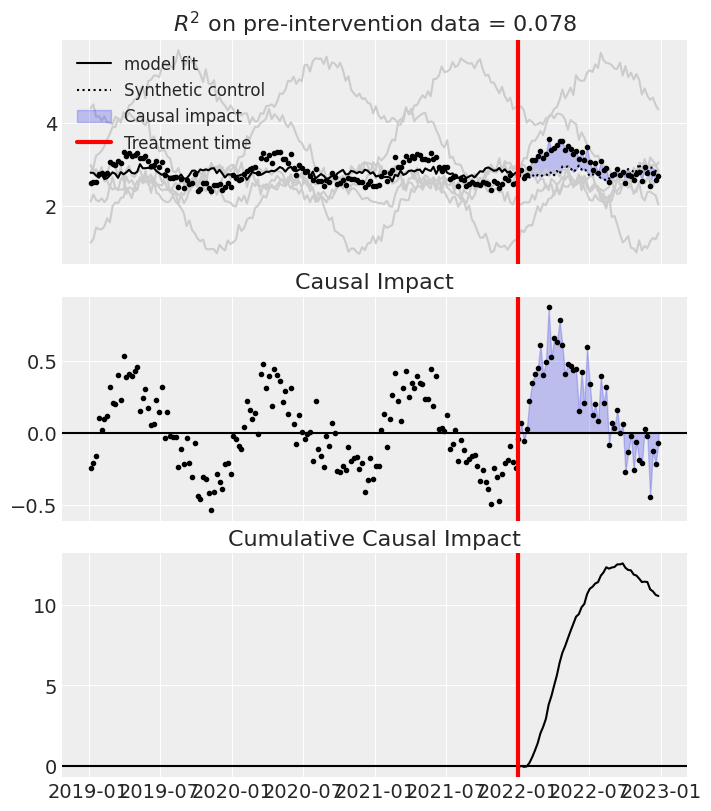

In [832]:
freq_est, ci_lower, ci_higher = get_freq_result(result_freq,  postfix = '0.2impact')

bayes bias-0.002000000000000668, frequentist bias 0.14171574109623641


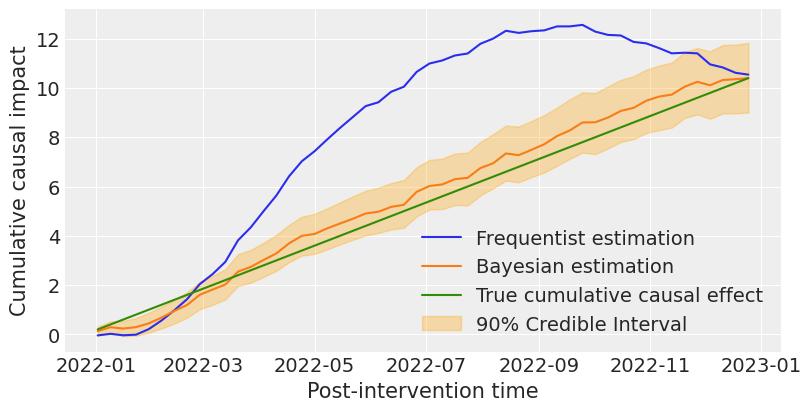

In [867]:
bayes_est, bias_bayes, bias_freq = compare_freq_bayes(result_freq, result_bayes, 0.2, 
                                                      freq_est, df_result_bayes, postfix = '0.2impact', freq ='W')

In [ ]:
# Plot both sets of intervals on the same figure

# Calculate error bar sizes for Frequentist method
freq_lower_error = freq_est - ci_lower  # Should equal 1.96 * sigma_j
freq_upper_error = ci_higher - freq_est

# Calculate error bar sizes for Bayesian method
bayes_lower = df_result_bayes['hdi_5%'].values[0]
bayes_higher = df_result_bayes['hdi_95%'].values[0]
bayes_lower_error = bayes_est - bayes_lower 
bayes_upper_error = bayes_higher - bayes_est

# Plot Frequentist CI at x = 1 (blue circle)
plt.errorbar(1, freq_est, 
             yerr=[[freq_lower_error], [freq_upper_error]],
             fmt='o', color='blue', capsize=5, label='Frequentist SC 90% CI')

# Plot Bayesian credible interval at x = 2 (red square)
plt.errorbar(2, bayes_est, 
             yerr=[[bayes_lower_error ], [bayes_upper_error]],
             fmt='s', color='orange', capsize=5, label='Bayesian SC 90% CrI')

plt.plot([0.8,2.5], [10.4, 10.4], linestyle = '-.', color = 'Green', label = 'Ground Truth')

# Add annotations without arrows
plt.text(1.05, freq_est + 0.5, 
         f'{freq_est:.2f}\n90% CI: [{ci_lower:.2f}, {ci_higher:.2f}]', 
         color='blue', fontsize=10)

plt.text(2.1, bayes_est - 0.5, 
         f'{bayes_est:.2f}\nCrI: [{bayes_lower:.2f}, {bayes_higher:.2f}]', 
         color='orange', fontsize=10)

# Customize the x-axis labels
plt.xticks([1, 2], ['Frequentist SC', 'Bayesian SC'])
plt.ylabel('Cumulative Causal Effect')
plt.title('Comparison of Frequentist SC CI vs Bayesian SC CrI')
plt.legend()
plt.grid(True)
plt.savefig("FreqSC_BayesSC_CI.pdf")
plt.show()


# Bayesian Multilevel Modleling / Partial Pooling

In [531]:
import pymc as pm

def generate_multiple_geo_tests(num_tests=10, mu=0.2, tau=0.05, pre_time_min=1, pre_time_max=4, 
                                start_years=(2018, 2021), freq='W'):
    """
    Generate multiple geo-test datasets with varied causal effects, ensuring:
    - Pre-treatment period is at least 1 year.
    - Pre-treatment period is always > post-treatment period.
    - Post-treatment period is at most 1 year.
    - Treatment date is always ≥ 2022-01-01.

    Args:
        num_tests (int): Number of geo-tests.
        mu (float): Mean of true causal effects.
        tau (float): Standard deviation of true causal effects.
        sigma_range (tuple): Range of noise levels (σ).
        pre_time_min (int): Minimum pre-campaign duration (in years).
        pre_time_max (int): Maximum pre-campaign duration (in years).
        start_years (tuple): Range of possible start years.
        freq (str): Time frequency ('W' for weeks, 'D' for days).

    Returns:
        list: A list of dictionaries containing geo-test datasets.
    """
    geo_tests = []

    for j in range(num_tests):
        valid_treatment_date = False
        while not valid_treatment_date:
            # Randomly pick start date within range
            start_year = np.random.randint(start_years[0], start_years[1] + 1)
            start_date = f"{start_year}-01-01"

            # Select pre-treatment period (1 to 4 years)
            pre_time = np.random.randint(pre_time_min, pre_time_max + 1)

            # Ensure treatment date is at least 2022-01-01
            treatment_date = pd.to_datetime(start_date) + pd.DateOffset(weeks=pre_time * 52)

            if treatment_date >= pd.to_datetime("2022-01-01"):
                valid_treatment_date = True

        # Select post-treatment period (1 to 52 weeks), ensuring post_time < pre_time
        post_time_weeks = np.random.randint(1, min(52, pre_time * 52))  # Convert years to weeks

        # Convert weeks to years for consistency
        post_time = post_time_weeks / 52  # Convert weeks to years

        total_years = pre_time + post_time  # Total duration for dataset


        # Generate true causal effect θ_j ~ N(μ, τ²)
        theta_j = np.random.normal(mu, tau)

        # Generate geo-test data
        df = generate_geolift_data(n_years=int(np.ceil(total_years)), causal_impact=theta_j, 
                                   treat_time=treatment_date, start_time=start_date, freq=freq)

        geo_tests.append({
            "data": df,
            "theta_j": theta_j,  # Noise level
            "start_date": start_date,
            "treatment_date": treatment_date,
            "pre_time": pre_time,
            "post_time": post_time
        })

    return geo_tests

In [548]:
# Generate 20 geo-tests with enforced pre_time > post_time and treatment date ≥ 2022-01-01
geo_tests = generate_multiple_geo_tests(num_tests=20, mu=0.3, tau = 0.3)

[0.13036006 0.22291363 0.20613979 0.11969017 0.10925858 0.21163777]
[0.16364277 0.16494236 0.08856395 0.07237051 0.07263112 0.43784929]
[0.23052269 0.00246447 0.36677289 0.0091908  0.35709795 0.03395119]
[0.0831825  0.00942845 0.42246719 0.24309262 0.1402585  0.10157075]
[0.23747052 0.08610205 0.18251058 0.16334699 0.31864205 0.0119278 ]
[0.21270617 0.22126196 0.0756528  0.36694872 0.05972931 0.06370104]
[0.18079417 0.01989134 0.15912271 0.19319994 0.07722036 0.36977148]
[0.09001666 0.00451018 0.07131199 0.38845709 0.09614415 0.34955992]
[0.11801299 0.26013035 0.07893825 0.21372002 0.27288038 0.05631801]
[0.141163   0.18291194 0.34938672 0.16924991 0.15646728 0.00082115]
[0.18111377 0.24215507 0.09402767 0.38257056 0.06750432 0.03262861]
[0.07761135 0.08821469 0.2320424  0.00773813 0.14441857 0.44997485]
[0.31900677 0.02050373 0.2542547  0.02069258 0.16513324 0.22040898]
[0.01697446 0.0021979  0.3625455  0.06146707 0.28028666 0.27652841]
[0.03428755 0.1016147  0.26803206 0.15667102 0.0

In [887]:
def plot_geo_test(geo_tests, i, title="Geo-Test Data Visualization"):
    """
    Plots the time series of the treated unit (Denmark) and control units,
    highlighting the treatment period.

    Args:
        geo_test (dict): A single geo-test dictionary from the generated dataset.
        title (str): Title of the plot.
    """
    geo_test = geo_tests[i]
    df = geo_test["data"]
    treatment_date = geo_test["treatment_date"]

    plt.figure(figsize=(10, 4))

    # Plot control units in gray
    control_units = [col for col in df.columns if col != "Denmark"]
    for control in control_units:
        plt.plot(df.index, df[control], color="gray", alpha=0.5, label="_nolegend_")

    # Plot treated unit (Denmark) in red
    plt.plot(df.index, df["Denmark"], color="red", label="Treated Unit", linewidth=2)

    # Mark the treatment time with a vertical dashed black line
    plt.axvline(x=treatment_date, color="black", linestyle="--", linewidth=2, label="Treatment Date")

    # Labels and legend
    plt.xlabel("Time")
    plt.ylabel("Outcome")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'geo_test_demo{i}.pdf')
    plt.show()


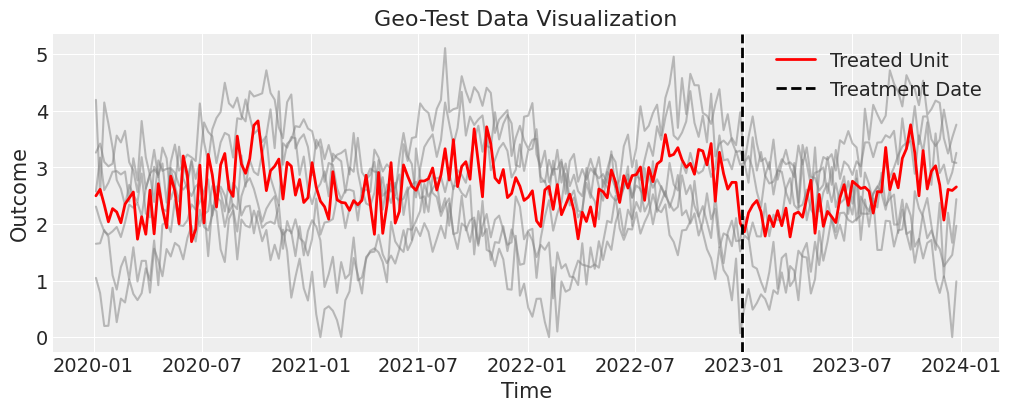

In [891]:
# Select one test and visualize it
plot_geo_test(geo_tests, 19)

In [711]:
formula = "Denmark ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic"
result_bayes_lst, result_freq_lst = [],[]
for i in range(len(geo_tests)):
    data = geo_tests[i]['data']
    treatment_time = geo_tests[i]['treatment_date']
    result_freq_i = freq_sc(data, formula, treatment_time)
    result_freq_lst.append(result_freq_i)


In [634]:
def get_freq_est_result(result_freq):
    estimated_causal_effect = result_freq_lst[i].post_impact.mean()
    n = len(result_freq_lst[i].post_impact)
    estimated_stderr = result_freq_lst[i].post_impact.std()/np.sqrt(n)
    return estimated_causal_effect, estimated_stderr

In [716]:
import pymc as pm

# Prepare Data: Extract causal effect estimates from each geo-test
estimated_effects = []

for i, test in enumerate(geo_tests):
    df = test["data"]
    treatment_time = test["treatment_date"]

    # Extract estimated causal effect
    estimated_freq_effect, estimated_freq_stderr = get_freq_est_result(result_freq_lst[i])
    #estimated_bayes_effect, estimated_bayes_stderr = get_bayes_est_result(result_bayes_lst[i])
    

    estimated_effects.append({
        "test_id": i,
        "true_theta": test["theta_j"],  # True causal effect from simulation
        "freq_estimated_effect": estimated_freq_effect,
        #"bayes_estimated_effect": estimated_bayes_effect,
        "sigma_j_freq": estimated_freq_stderr,  # Noise level (uncertainty) in effect estimation
        #"sigma_j_bayes": estimated_bayes_stderr
        
    })

# Convert to DataFrame
effect_df = pd.DataFrame(estimated_effects)

# Extract necessary data
y_obs_freq = effect_df["freq_estimated_effect"].values
sigma_freq_vals = effect_df["sigma_j_freq"].values
num_tests = len(effect_df)


In [717]:
def bayesian_hierachical_model(effect_df, estimate = 'freq'):
    if estimate == 'freq':
        y_obs = effect_df["freq_estimated_effect"].values
        sigma_vals = effect_df["sigma_j_freq"].values
    else:
        y_obs = effect_df["bayes_estimated_effect"].values
        sigma_vals = effect_df["sigma_j_bayes"].values
        
    num_tests = len(effect_df)
    with pm.Model() as hierarchical_model:
        # **Hyperpriors: Pooling Information Across Tests**
        mu = pm.Normal("mu", mu=0, sigma=1)  # Global mean causal effect
        tau = pm.HalfCauchy("tau", beta=1)   # Between-geo-test variation
    
        # **Individual geo-test effects**
        theta = pm.Normal("theta", mu=mu, sigma=tau, shape=num_tests)
    
        # **Observed causal effect estimates (Frequentist estimation)**
        y_likelihood = pm.Normal("y_obs", mu=theta, sigma=sigma_vals, observed=y_obs)
    
        # **MCMC Sampling**
        trace = pm.sample(4000, tune=2000, target_accept=0.95, chains=4, return_inferencedata=True)

    # **Summarize Posterior Distributions**
    print(az.summary(trace, var_names=["mu", "tau", "theta"]))
    return trace

    

In [555]:
trace = bayesian_hierachical_model(effect_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 12 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu         0.30  0.07    0.17     0.45   1.00e-03      0.0   20922.0   
tau        0.32  0.06    0.22     0.43   0.00e+00      0.0   19050.0   
theta[0]   0.46  0.04    0.38     0.54   0.00e+00      0.0   24916.0   
theta[1]   0.45  0.05    0.36     0.55   0.00e+00      0.0   24508.0   
theta[2]   0.92  0.06    0.81     1.03   0.00e+00      0.0   24622.0   
theta[3]   0.31  0.04    0.23     0.39   0.00e+00      0.0   24145.0   
theta[4]  -0.26  0.04   -0.34    -0.17   0.00e+00      0.0   22591.0   
theta[5]   0.33  0.04    0.25     0.41   0.00e+00      0.0   24016.0   
theta[6]   0.61  0.06    0.50     0.73   0.00e+00      0.0   24536.0   
theta[7]   0.18  0.04    0.10     0.26   0.00e+00      0.0   25022.0   
theta[8]   0.18  0.05    0.09     0.27   0.00e+00      0.0   25432.0   
theta[9]   0.19  0.05    0.08     0.29   0.00e+00      0.0   24736.0   
theta[10] -0.07  0.05   -0.16     0.03   0.00e+00      0.0   240

In [ ]:
def get_bayes_est_result(result_bayes):
    point_estimate_grid = result_bayes.post_impact.sel({"obs_ind": index})
    df_result_bayes = az.summary(point_estimate_grid, hdi_prob=0.9, kind="stats")
    point_estimate = df_result_bayes['mean'].values[0]
    std_err = df_result_bayes['sd'].values[0] / np.sqrt(len(result_bayes.post_y))
    return point_estimate, std_err

In [762]:
 # Extract posterior mean estimates from Bayesian model
bayesian_theta_estimates_freq = trace.posterior["theta"].mean(dim=("chain", "draw")).values
bayesian_summary = az.summary(trace, var_names=["theta"], hdi_prob=0.9)
# Store in DataFrame
effect_df["bayesian_pooling_est"] = bayesian_theta_estimates_freq
effect_df["bayesian_pooling_est_hdi5%"] = bayesian_summary['hdi_5%'].values
effect_df["bayesian_pooling_est_hdi95%"] = bayesian_summary['hdi_95%'].values


In [892]:
def visualize_bayes_pooling(effect_df, est = 'freq'):
    if est == 'freq':
        estimate = effect_df["freq_estimated_effect"]
        pooling = effect_df["bayesian_pooling_est"]
        label = "Unpooled Estimates"
        title = "Unpooled Estimates vs Bayesian Pooled Estimates"
    else:
        estimate = effect_df["bayes_estimated_effect"]
        pooling = effect_df["bayesian_pooling_bayes_est"]
        label = "Bayesian Estimates"
        title = "Bayesian Estimates vs Bayesian Pooled Estimates"
        
    plt.figure(figsize=(10, 6))
    plt.scatter(effect_df["true_theta"], estimate, label=label, alpha=0.7)
    plt.scatter(effect_df["true_theta"], pooling, label="Bayesian Pooled Estimates", alpha=0.7)
    plt.plot([-0.6, 1.1], [-0.6, 1.1], linestyle="--", color="black")  # Perfect estimation line
    plt.xlabel("True Causal Effect (θ)")
    plt.ylabel("Estimated Causal Effect")
    plt.title(title)
    plt.legend()
    plt.savefig('Frequentist_pooling.pdf')
    plt.show()
    plt.close()

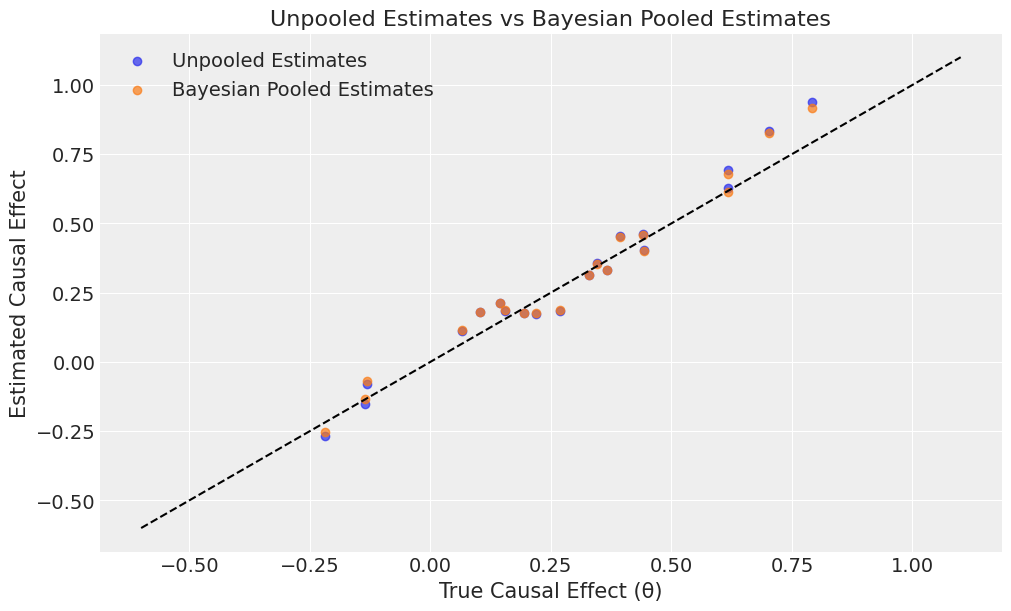

In [893]:
visualize_bayes_pooling(effect_df, est = 'freq')

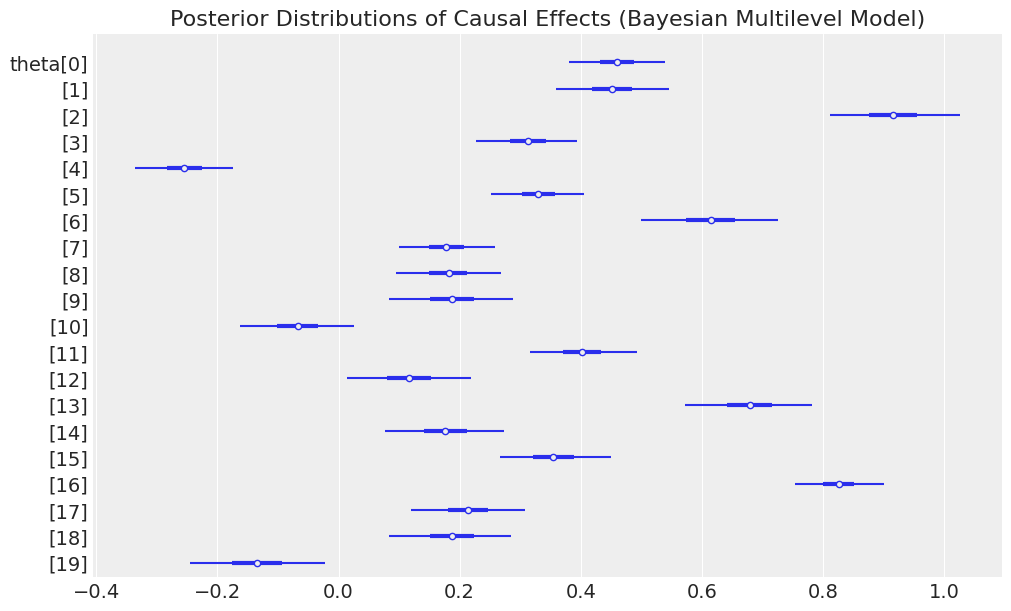

In [725]:
# Plot posterior distributions of treatment effects for each geo-test
az.plot_forest(trace, var_names=["theta"], combined=True, figsize=(10, 6))
plt.title("Posterior Distributions of Causal Effects (Bayesian Multilevel Model)")
plt.savefig("Bayesian_pooling_posterior.pdf")
plt.show()
plt.close()

In [894]:
def compare_CI(df):

    # Example DataFrame (replace with your actual DataFrame)
    # df = pd.read_csv('your_file.csv')
    # For demonstration, here's a dummy DataFrame with 20 points:
    
    # Calculate Frequentist 95% CI using sigma_j
    df["freq_est_low5"] = df["freq_estimated_effect"] - 1.625 * df["sigma_j_freq"]
    df["freq_est_high95"] = df["freq_estimated_effect"] + 1.625 * df["sigma_j_freq"]
    
    # Create an x-axis for the 20 points (e.g., geo-test index)
    x = np.arange(len(df))
    
    # Calculate asymmetric error bars for frequentist estimates
    freq_lower_error = df["freq_estimated_effect"] - df["freq_est_low5"]
    freq_upper_error = df["freq_est_high95"] - df["freq_estimated_effect"]
    
    # Calculate asymmetric error bars for Bayesian estimates
    bayes_lower_error = df["bayesian_pooling_est"] - df["bayesian_pooling_est_hdi5%"]
    bayes_upper_error = df["bayesian_pooling_est_hdi95%"] - df["bayesian_pooling_est"]
    
    # Plot both sets of intervals on the same figure
    plt.figure(figsize=(10, 6))
    
    # Plot Frequentist point estimates with CI error bars (blue circles)
    plt.errorbar(
        x,
        df["freq_estimated_effect"],
        yerr=[freq_lower_error, freq_upper_error],
        fmt='o',
        color='blue',
        capsize=5,
        label="Unpooled 90% CI"
    )
    
    # Plot Bayesian point estimates with CrI error bars (red squares)
    plt.errorbar(
        x,
        df["bayesian_pooling_est"],
        yerr=[bayes_lower_error, bayes_upper_error],
        fmt='s',
        color='orange',
        capsize=5,
        label="Bayesian Pooling 90% CrI"
    )
    
    plt.xlabel("Geo-tests")
    plt.ylabel("Causal Effect Estimate")
    plt.title("Comparison of Unpooled CI vs Bayesian Pooling CrI")
    plt.legend()
    plt.grid(True)
    plt.savefig("freq_bayespool_ci_compare.pdf")
    plt.show()
    plt.close()


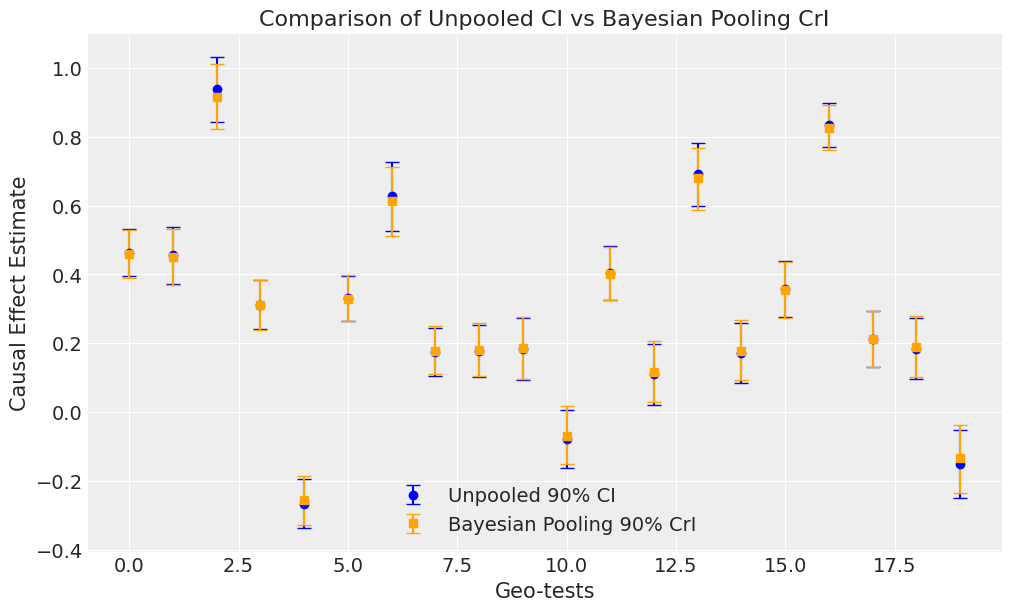

In [895]:
compare_CI(effect_df)

In [908]:
def evaluate(effect_df):
    error_freq = effect_df['freq_estimated_effect'] - effect_df['true_theta']
    error_bayes = effect_df['bayesian_pooling_est'] - effect_df['true_theta']
    data = [error_freq.values, error_bayes.values]
    print(error_freq.median(), error_bayes.median())

    bias_freq = error_freq.mean()
    bias_bayes = error_bayes.mean()
    
    mae_freq = np.mean(np.abs(error_freq))
    mae_bayes = np.mean(np.abs(error_bayes))

    rmse_freq = np.sqrt((np.mean(error_freq ** 2)))
    rmse_bayes = np.sqrt((np.mean(error_bayes ** 2)))

    df = pd.DataFrame({"bias_unpooled": bias_freq,
         "bias_bayes_pooling": bias_bayes,
         "mae_unpooled": mae_freq,
         "mae_bayes_pooling": mae_bayes,
         "rmse_unpooled": rmse_freq,
         "rmse_bayes_pooling": rmse_bayes}, index=[0])

    df.to_csv("freq_bayes_pooling_evaluation.csv")

    # Create the boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, labels=['Unpooled', 'Bayesian Pooling'])
    plt.ylabel('Error')
    plt.title('Unpooled vs Bayesian Pooling')
    plt.savefig('Frequentist_bayesian_pooling_eval.pdf')
    plt.show()
    plt.close()
    return df
    

0.016590076636971568 0.014146276376179323


/var/folders/k0/2l9bww7s36l4cnx2cr0mhq5m0000gn/T/ipykernel_33311/3811630529.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Unpooled', 'Bayesian Pooling'])


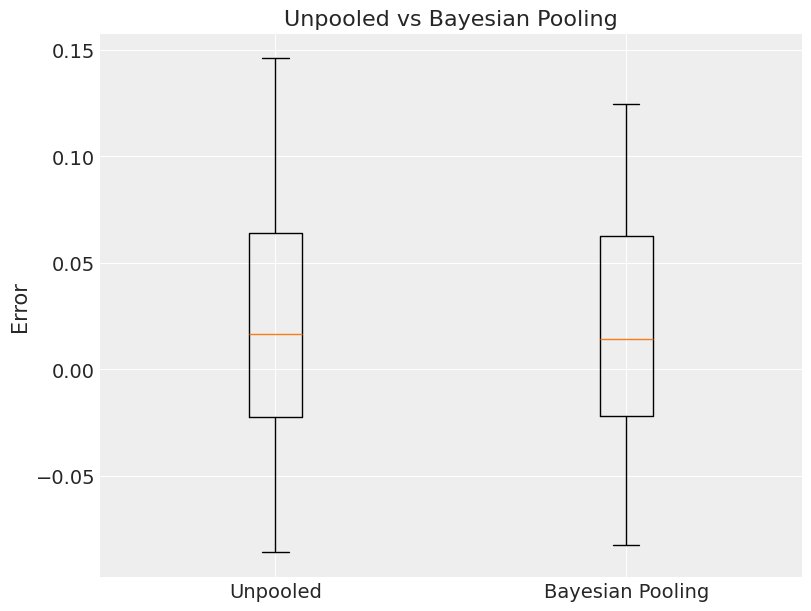

In [909]:
evaluation_df = evaluate(effect_df)

In [910]:
pd.options.display.precision = 5
evaluation_df.T

,0
bias_unpooled,0.02138
bias_bayes_pooling,0.02124
mae_unpooled,0.05185
mae_bayes_pooling,0.04846
rmse_unpooled,0.06352
rmse_bayes_pooling,0.05956


In [900]:
effect_df

,test_id,true_theta,freq_estimated_effect,sigma_j_freq,bayesian_pooling_est,bayesian_pooling_est_hdi5%,bayesian_pooling_est_hdi95%,freq_est_low5,freq_est_high95
0,0,0.4415,0.4629,0.0423,0.4597,0.391,0.529,0.3941,0.5317
1,1,0.3924,0.4553,0.0511,0.4516,0.368,0.532,0.3723,0.5383
2,2,0.7912,0.9372,0.0577,0.9156,0.822,1.011,0.8435,1.0310
3,3,0.3296,0.3121,0.0442,0.3123,0.239,0.384,0.2403,0.3839
4,4,-0.2187,-0.2659,0.0435,-0.2546,-0.327,-0.186,-0.3367,-0.1952
5,5,0.3665,0.3304,0.0406,0.3300,0.266,0.399,0.2644,0.3963
6,6,0.6170,0.6271,0.0618,0.6144,0.513,0.711,0.5267,0.7276
7,7,0.1936,0.1758,0.0429,0.1782,0.110,0.249,0.1060,0.2455
8,8,0.1019,0.1787,0.0467,0.1817,0.105,0.259,0.1029,0.2545
9,9,0.2695,0.1836,0.0556,0.1871,0.097,0.276,0.0933,0.2739
